In [1]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["cartopy", "cf_xarray", "netcdf4", "odvc", "pysgrid", "pyugrid"]
_colab_install_missing_deps(deps)

# Parsing Conventions and standards with Python

Created: 2019-11-16

Updated: 2024-03-14

Metadata conventions, like the Climate and Forecast (CF) conventions,
can be cumbersome to adhere to but it will be very handy when you or other users manipulate the data later in time.

In this notebook we will explore three Python modules that parse [`CF-1.6`](https://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html),
[`UGRID-1.0`](https://ugrid-conventions.github.io/ugrid-conventions/),
and [`SGRID-0.3`](https://sgrid.github.io/sgrid/)

## CF-1.6 with cf_xarray

There are many Python libraries to read and write CF metadata,
including [`iris`](https://scitools-iris.readthedocs.io/en/stable/) and [`cf_xarray`](https://cf-xarray.readthedocs.io/en/latest/).

We will explore `cf_xarray` in this notebook because it is built on top of the popular `xarray` package.

In [2]:
import cf_xarray

print(cf_xarray.__version__)
import xarray as xr

url = "http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/his/ESPRESSO_Real-Time_v2_History_fmrc.ncd"
ds = xr.open_dataset(
    url, drop_variables="time"
)  # see https://github.com/pydata/xarray/issues/2233 for more context on dropping the time variable here.
ds.cf

0.8.9


SGRID:
             CF role:   grid_topology: ['grid']

                Axes: * X: ['xi_psi', 'xi_rho', 'xi_u', 'xi_v']
                      * Y: ['eta_psi', 'eta_rho', 'eta_u', 'eta_v']
                      * Z: ['s_rho', 's_w']

Coordinates:
             CF Axes: * Z: ['s_rho', 's_w']
                      * T: ['ocean_time']
                        X, Y: n/a

      CF Coordinates:   longitude: ['lon_psi', 'lon_rho', 'lon_u', 'lon_v']
                        latitude: ['lat_psi', 'lat_rho', 'lat_u', 'lat_v']
                      * vertical: ['s_rho', 's_w']
                      * time: ['ocean_time']

       Cell Measures:   area, volume: n/a

      Standard Names: * forecast_reference_time: ['run']
                        latitude: ['lat_psi', 'lat_rho', 'lat_u', 'lat_v']
                        longitude: ['lon_psi', 'lon_rho', 'lon_u', 'lon_v']
                      * ocean_s_coordinate_g1: ['s_rho', 's_w']

              Bounds:   n/a

       Grid Mappings:   n/a

Data Variab

The `cf_xarray` package does not compute the vertical coordinate (yet) as `iris`. However, we can easily compute it using the formula term in the metadata. To reduce the data download a bit we define a slice for the latest time step and a random point in the ocean.

In [3]:
from odvc.formulas import ocean_s_coordinate_g1

# Our ocean slice:
run, ocean_time, x, y = -1, -1, 42, 42

s = ds.cf["s_rho"]
C = ds.cf["Cs_r"]
eta = ds.cf["zeta"][run, ocean_time, x, y]
depth = ds.cf["h"][x, y]
depth_c = ds.cf["hc"]

z = ocean_s_coordinate_g1(s, C, eta, depth, depth_c)

/tmp/ipykernel_28883/1323880464.py:8: UserWarning: Variables {'', 'time'} not found in object but are referred to in the CF attributes.
  eta = ds.cf["zeta"][run, ocean_time, x, y]
/tmp/ipykernel_28883/1323880464.py:9: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  depth = ds.cf["h"][x, y]


The main advantage of the CF data model are:

- high level variable access via standard_name or long_name;
- verbose warnings when there are compliance issues (see the warnings above);
- raise errors for non-compliant datasets;
- each CF object\* is a fully self-described format with all the original metadata;
- round-trip load-save to netCDF is lossless;
- free interpretation of the formula_terms\*, cell_methods, and axis that helps with dimensionless coordinates, climatological variables, and plotting routines respectively.

\* note that the pure xarray infringes the CF model in many places, see the `drop_variables=time` we used to be able to load the data. We recommend xarray when CF compliance is not a hard requirement.

\*\* only in iris at the moment.

In [4]:
temp = ds.cf["sea_water_potential_temperature"]

temp

/tmp/ipykernel_28883/4185694592.py:1: UserWarning: Variables {'', 'time'} not found in object but are referred to in the CF attributes.
  temp = ds.cf["sea_water_potential_temperature"]


<xarray.DataArray 'temp' (run: 1929, time: 157, s_rho: 36, eta_rho: 82,
                          xi_rho: 130)> Size: 465GB
[116222867280 values with dtype=float32]
Coordinates:
  * run      (run) datetime64[ns] 15kB 2013-05-18 2013-05-19 ... 2018-09-14
  * s_rho    (s_rho) float64 288B -0.9861 -0.9583 -0.9306 ... -0.04167 -0.01389
    lat_rho  (eta_rho, xi_rho) float64 85kB 33.74 33.79 33.84 ... 42.82 42.87
    lon_rho  (eta_rho, xi_rho) float64 85kB -75.84 -75.78 ... -71.49 -71.43
Dimensions without coordinates: time, eta_rho, xi_rho
Attributes:
    units:          Celsius
    long_name:      potential temperature
    time:           ocean_time
    field:          temperature, scalar, series
    _ChunkSizes:    [  1  36  82 130]
    standard_name:  sea_water_potential_temperature

In [5]:
# Surface at the last time step.
T = temp[-1, -1, -1, ...]

# Random profile at the last time step.
t_profile = temp[-1, -1, :, 42, 42]

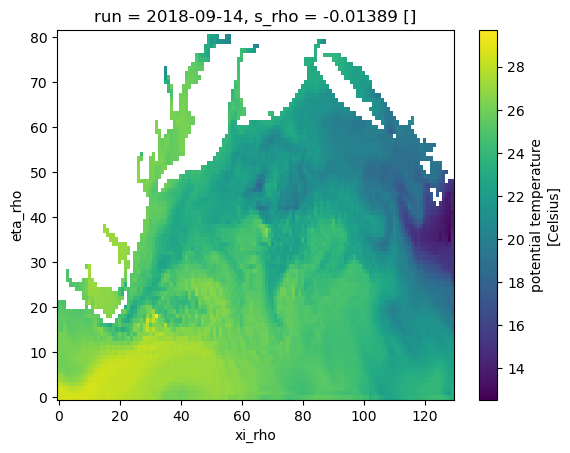

In [6]:
T.plot();

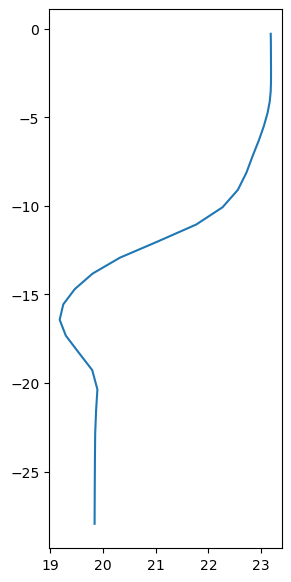

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3, 7))

ax.plot(t_profile, z);

## UGRID-1.0 with pyugrid

The Unstructured Grids convention encompasses any type of grid topology,
and the details of the convention are documented in [https://ugrid-conventions.github.io/ugrid-conventions](https://ugrid-conventions.github.io/ugrid-conventions/).
Right now `pyugrid` supports only triangular topologies, more will be added in the near future.

In a nutshell the `pyugrid` parses and exposes the underlying grid topology in a python object.

In [8]:
import pyugrid

url = "http://test.opendap.org:8080/opendap/ugrid/NECOFS_GOM3_FORECAST.nc"
ugrid = pyugrid.UGrid.from_ncfile(url)

Sometimes the topology is incomplete but,
if the data is `UGRID` compliant,
`pyugrid` can derive the rest for you.

In [9]:
ugrid.build_edges()

The topology can be extracted from `ugrid` object and used for plotting.

In [10]:
lon = ugrid.nodes[:, 0]
lat = ugrid.nodes[:, 1]
triangles = ugrid.faces[:]

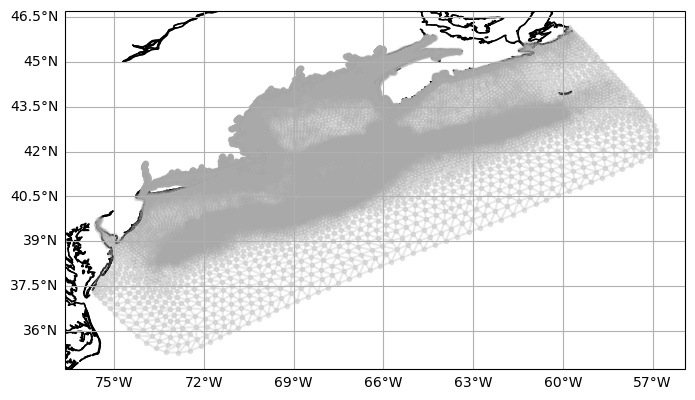

In [11]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=projection))
    ax.coastlines(resolution="50m")
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax


fig, ax = make_map()

kw = {"marker": ".", "linestyle": "-", "alpha": 0.25, "color": "darkgray"}
ax.triplot(lon, lat, triangles, **kw)
ax.coastlines();

Check a longer `pyugrid` example [here](https://ocefpaf.github.io/python4oceanographers/blog/2015/07/20/pyugrid/).

## SGRID-0.3 with `pysgrid`

The Staggered Grid conventions help users to interpret grids from models like ROMS and DELFT,
where the variables are defined in different grids.
The specs are detailed in [https://sgrid.github.io/sgrid](https://sgrid.github.io/sgrid).

The `pysgrid` module is similar to `pyugrid`. The grid topology is parsed into a Python object with methods and attributes that translate the SGRID conventions.

In [12]:
import pysgrid

url = (
    "http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best"
)
sgrid = pysgrid.load_grid(url)

All the raw grid information is present, like edges, dimensions, padding, grid center, and slicing.

In [13]:
sgrid.edge1_coordinates, sgrid.edge1_dimensions, sgrid.edge1_padding

(('lon_u', 'lat_u'),
 'xi_u: xi_psi eta_u: eta_psi (padding: both)',
 [GridPadding(mesh_topology_var='grid', face_dim='eta_u', node_dim='eta_psi', padding='both')])

In [14]:
u_var = sgrid.u

u_var.center_axis, u_var.node_axis

(1, 0)

In [15]:
v_var = sgrid.v
v_var.center_axis, v_var.node_axis

(0, 1)

In [16]:
u_var.center_slicing, v_var.center_slicing

((slice(None, None, None),
  slice(None, None, None),
  slice(1, -1, None),
  slice(None, None, None)),
 (slice(None, None, None),
  slice(None, None, None),
  slice(None, None, None),
  slice(1, -1, None)))

The API is "raw" but comprehensive.
There is plenty of room to create convenience methods using the low level access provided by the library.

See below an example of the API and some simple convenience methods to `slice`, `pad`, `average`, and `rotate` the structure grid for plotting.

In [17]:
from netCDF4 import Dataset

# Compute the speed.
# **Rotate the grid.
# Average at the center.
from pysgrid.processing_2d import avg_to_cell_center, rotate_vectors, vector_sum

nc = Dataset(url)
u_velocity = nc.variables[u_var.variable]
v_velocity = nc.variables[v_var.variable]

v_idx = 0  # surface
time_idx = 0  # First time step.

u = u_velocity[time_idx, v_idx, u_var.center_slicing[-2], u_var.center_slicing[-1]]
v = v_velocity[time_idx, v_idx, v_var.center_slicing[-2], v_var.center_slicing[-1]]


u = avg_to_cell_center(u, u_var.center_axis)
v = avg_to_cell_center(v, v_var.center_axis)


angles = nc.variables[sgrid.angle.variable][sgrid.angle.center_slicing]
u, v = rotate_vectors(u, v, angles)


speed = vector_sum(u, v)

\*\* CF convention does describe the angle variable for grids that needs rotation, but there is no action expected. For example, in the formula_terms, pysgrid must be improved to abstract that action when needed via a simpler method.

```xml
<entry id="angle_of_rotation_from_east_to_x">
    <canonical_units>degree</canonical_units>
    <grib></grib>
    <amip></amip>
    <description>The quantity with standard name angle_of_rotation_from_east_to_x is the angle, anticlockwise reckoned positive, between due East and (dr/di)jk, where r(i,j,k) is the vector 3D position of the point with coordinate indices (i,j,k).  It could be used for rotating vector fields between model space and latitude-longitude space.</description>
</entry>
```

In [18]:
lon_var_name, lat_var_name = sgrid.face_coordinates

sg_lon = getattr(sgrid, lon_var_name)
sg_lat = getattr(sgrid, lat_var_name)

lon = sgrid.center_lon[sg_lon.center_slicing]
lat = sgrid.center_lat[sg_lat.center_slicing]

Let's subset and center the velocity for better visualization (not a mandatory step but recommended).

In [19]:
def is_monotonically_increasing(arr, axis=0):
    return np.all(np.diff(arr, axis=axis) > 0)


def is_monotonically_decreasing(arr, axis=0):
    return np.all(np.diff(arr, axis=axis) < 0)


def is_monotonic(arr):
    return is_monotonically_increasing(arr) or is_monotonically_decreasing(arr)


def extent_bounds(arr, bound_position=0.5, axis=0):
    if not is_monotonic(arr):
        msg = "Array {!r} must be monotonic to guess bounds".format
        raise ValueError(msg(arr))

    x = arr.copy()
    x = np.c_[x[:, 0], (bound_position * (x[:, :-1] + x[:, 1:])), x[:, -1]]
    x = np.r_[
        x[0, :][None, ...],
        (bound_position * (x[:-1, :] + x[1:, :])),
        x[-1, :][None, ...],
    ]

    return x

In [20]:
import numpy as np

# For plotting reasons we will subsample every 10th point here
# 100 times less data!
sub = 10

lon = lon[::sub, ::sub]
lat = lat[::sub, ::sub]
u, v = u[::sub, ::sub], v[::sub, ::sub]
speed = speed[::sub, ::sub]

x = extent_bounds(lon)
y = extent_bounds(lat)

Now we can use quiver to plot the velocity components in a single grid.

In [21]:
def make_map(projection=ccrs.PlateCarree(), figsize=(9, 9)):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

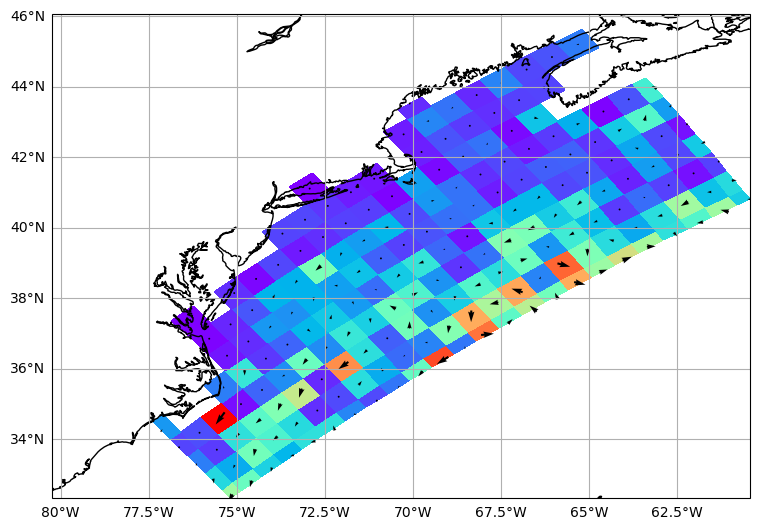

In [22]:
scale = 0.06

fig, ax = make_map()

kw = dict(scale=1.0 / scale, pivot="middle", width=0.003, color="black")
q = plt.quiver(lon, lat, u, v, zorder=2, **kw)

plt.pcolormesh(x, y, speed, zorder=1, cmap=plt.cm.rainbow)

c = ax.coastlines("10m")

For more examples on `pysgrid` check this [post](https://ocefpaf.github.io/python4oceanographers/blog/2015/12/07/pysgrid/) out.